In [62]:
#numpy, matplotlib, pandasのインポート
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import unicodedata
from matplotlib import rcParams
import seaborn as sns

# notebookの設定

# データフレームの最大表示行数、列数を広げる
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

# 図のサイズ
plt.rcParams["figure.figsize"]=(8,4)

# matplotlibのフォント
font = 'Yu Mincho'

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Meiryo']

C:\Users\yutak\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [75]:
#学習データ、テストデータの読み込み
train0 = pd.read_csv('dataset/train.csv')
test0 = pd.read_csv('dataset/test.csv')

In [76]:
# 不要な変数の削除

# 変数名と列番号の対応を表示
col = pd.DataFrame(train0.columns.values).T

# dropの実行,事故率に関係ないデータは予測に利用できないのでdrop(後々他の変数をdropしたくなった時楽な様に列番号でdropする)
train1 = train0.drop(train0.columns[0],axis=1) 
test1 = test0.drop(test0.columns[0],axis=1)

In [81]:
value_list = train0['Age'].tolist()
list(dict.fromkeys(value_list))


['50歳',
 '56歳',
 nan,
 '三十七歳',
 '48歳',
 '19歳',
 '47歳',
 '49歳',
 '33歳',
 '３１歳',
 '51歳',
 '46歳',
 '４９歳',
 '53才',
 '20歳',
 '25歳',
 '五十三歳',
 '20代',
 '44歳',
 '30歳',
 '34歳',
 '29歳',
 '30代',
 '41歳',
 '50代',
 '52歳',
 '22歳',
 '３６歳',
 '28歳',
 '25才',
 '五十一歳',
 '48才',
 '38才',
 '三十三歳',
 '42際',
 '５０代',
 '35才',
 '59歳',
 '四十三歳',
 '32歳',
 '４２才',
 '53歳',
 '58歳',
 '40代',
 '二十六歳',
 '52際',
 '54歳',
 '59才',
 '29才',
 '21才',
 '57歳',
 '37歳',
 '35歳',
 '36才',
 '38歳',
 '３７歳',
 '50才',
 '51才',
 '43歳',
 '四十歳',
 '26歳',
 '31歳',
 '27歳',
 '40歳',
 '３４歳',
 '40際',
 '21歳',
 '24才',
 '45歳',
 '36歳',
 '41才',
 '38際',
 '18歳',
 '39歳',
 '４６歳',
 '４０代',
 '５５歳',
 '58際',
 '24歳',
 '41際',
 '三十一歳',
 '52才',
 '３０代',
 '28才',
 '55際',
 '60代',
 '27際',
 '３２歳',
 '60歳',
 '五十四歳',
 '29際',
 '三十四歳',
 '４７歳',
 '37際',
 '二十四歳',
 '四十七歳',
 '58才',
 '39才',
 '23才',
 '３３歳',
 '４２歳',
 '４５歳',
 '３９歳',
 '５４歳',
 '55歳',
 '42歳',
 '３８歳',
 '47才',
 '５１歳',
 '３９才',
 '51際',
 '二十七歳',
 '30才',
 '２６歳',
 '４０歳',
 '36際',
 '三十歳',
 '23歳',
 '二十二歳',
 '37才',
 '３０歳',
 '２８歳',
 '34才',
 '五十歳

In [78]:
def preprocessing(train1, test1):
    # Age numeric
    # 漢数字とアラビア数字のマッピング
    kanji_to_num = {'一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9,'十': 10, '百': 100, '千': 1000, '万': 10000,'零': 0, '〇': 0}
    def kanji_to_arabic(kanji):
        result = 0
        temp = 0
        for char in kanji:
            value = kanji_to_num.get(char, None)
            if value is not None:
                if value < 10:
                    if temp == 0:
                        temp = value
                    else:
                        temp = temp * 10 + value
                elif value >= 10:
                    if temp == 0:
                        temp = 1
                    result += temp * value
                    temp = 0
        return result + temp
    def process_age(age):
        if age is None or str(age) == 'nan':
            return None
        age = unicodedata.normalize('NFKC', age)
        age = ''.join([c for c in age if c.isdigit() or c in kanji_to_num])
        if age.isdigit():
            return int(age)
        return kanji_to_arabic(age)

    # TypeofContact categorical(dummy)
    def TypeofContact_to_dummy(str):
        if str == 'Self Enquiry':
            return 1
        elif str == 'Company Invited':
            return 0
        
    # CityTier 順序尺度
    
    # DurationOfPitch numeric
    def convert_to_minutes(duration):
        # durationがfloat型またはNoneである可能性があるため、文字列であることを確認
        if pd.isnull(duration):
            return None  # NaNの場合、Noneを返す
        duration = str(duration)  # 文字列に変換してエラーを防ぐ
        if '分' in duration:
            return float(duration.replace('分', ''))
        elif '秒' in duration:
            return float(duration.replace('秒', '')) / 60  # 秒を分に変換し、整数で返す

    # Occupation categorical
    def Occupation_to_dummy(str):
        if str == 'Large Business':
            return 2
        elif str == 'Small Business':
            return 1
        elif str == 'Salaried':
            return 0
       
    # Gender categorical
    def Gender_dealing(gender):
        # 文字列を半角に変換し、大文字に統一
        gender = unicodedata.normalize('NFKC', gender).upper().strip()
        # 不要な空白を削除
        gender = ''.join(gender.split())

        if 'FEMALE' in gender:
            return 1
        elif 'MALE' in gender:
            return 0
        else:
            return None  # 性別が識別できない場合はNoneを返す
        
    # NumberOfPersonVisiting numeric
    
    # NumberOfFollowups numeric
    def NumberOfFollowups_dealing(input_int):
        if input_int >= 100:
            return input_int /100
        else:
            return input_int
    
    # ProductPitched categorical
    # Designation categorical
    def standardize_str(input_str):
        # 文字列を半角に変換し、小文字に統一
        input_str = unicodedata.normalize('NFKC', input_str).lower().strip()
        # 不要な空白や特殊記号を削除
        input_str = ''.join(input_str.split())
        input_str = input_str.replace('|', 'l').replace('×', 'x').replace('𝘤', 'c').replace('𝖺', 'a').replace('𝙳', 'd')
        # その他特殊文字を通常の英字に置換
        input_str = input_str.replace('ᗞ', 'd').replace('𐊡', 'a').replace('𝘳', 'r').replace('ꓢ', 's').replace('ı', 'i')
        input_str = input_str.replace('β', 'b').replace('в', 'b').replace('с', 'c').replace('տ', 's').replace('ς', 'c')
        input_str = input_str.replace('ꭰ', 'd').replace('ε', 'e').replace('ι', 'i').replace('α', 'a').replace('ո', 'n')
        input_str = input_str.replace('ѕ', 's').replace('μ', 'm').replace('е', 'e').replace('а', 'a').replace('ѵ', 'v')
        input_str = input_str.replace('aasic', 'basic')
        return input_str
    
    # PreferredPropertyStar 順序尺度
    
    # NumberOfTrips numeric
    def NumberOfTrips_dealing(str):
        if pd.isnull(str):
            return None 
        if '半年に' in str:
            return 2 * int(str.replace('半年に', '').replace('回', ''))
        elif '年に' in str:
            return int(str.replace('年に', '').replace('回', ''))
        elif '四半期に' in str:
            return 4 * int(str.replace('四半期に', '').replace('回', ''))
        else :
            return int(str)
        
    # Passport categorical(dummy)
    
    # PitchSatisfactionScore 順序尺度だけど間隔尺度的要素あり
    
    # MonthlyIncome numeric
    def MonthlyIncome_dealing(input_str):
        if pd.isnull(input_str):
            return None 
        if '月収' in input_str:
            return 10000 * float(input_str.replace('月収', '').replace('万円', ''))
        elif '万円' in input_str:
            return 10000 * float(input_str.replace('万円', ''))
        else:
            return float(input_str)
        
    # customer_info
    def customer_info_dealing(input_str):
        # 文字列を半角に変換し、小文字に統一
        input_str = unicodedata.normalize('NFKC', input_str).lower().strip()
        # 不要な空白や特殊記号を削除
        input_str = input_str.replace('/', ' ').replace('／', ' ').replace('、', ' ').replace('　', ' ')
        input_str = input_str.replace('\u3000', ' ').replace('\t', ' ').replace('\n', ' ')
        input_str = re.sub(r'(?<=\S)\s+(?=\S)', ',', input_str, count=2)
        return input_str
    
    # married categorical
    def married_dealing(input_str):
        if input_str == '独身':
            return 0
        elif input_str == '未婚':
            return 1
        elif input_str == '結婚済み':
            return 2
        elif input_str == '離婚済み':
            return 3
    
    # car_possesion categorival
    def car_possesion_dealing(input_str):
        if input_str in ['車未所持', '自動車未所有', '自家用車なし', '乗用車なし', '車なし', '車保有なし', 0]:
            return 0
        elif input_str in ['車所持', '自動車所有', '自家用車あり', '乗用車所持', '車保有', '車あり', 1]:
            return 1
        
    # offspring -1以外はnumeric
    def offspring_dealing(input_str):
        if '1' in input_str:
            return 1
        elif '2' in input_str:
            return 2
        elif '3' in input_str:
            return 3
        elif input_str in ['子供なし', '子供無し', '子供ゼロ', '非育児家庭', '無子']:
            return 0
        elif input_str in ['子供の数不明', '不明', 'わからない', '子育て状況不明', '子の数不詳']:
            return -1
        
    def function_apply(input_df):
        df = input_df.copy()
        df['Age'] = df['Age'].apply(process_age)
        df['TypeofContact'] = df['TypeofContact'].apply(TypeofContact_to_dummy)
        df['DurationOfPitch'] = df['DurationOfPitch'].apply(convert_to_minutes)
        df['Occupation'] = df['Occupation'].apply(Occupation_to_dummy)
        df['Gender'] = df['Gender'].apply(Gender_dealing)
        df['NumberOfFollowups'] = df['NumberOfFollowups'].apply(NumberOfFollowups_dealing)
        df['ProductPitched'] = df['ProductPitched'].apply(standardize_str)
        df['NumberOfTrips'] = df['NumberOfTrips'].apply(NumberOfTrips_dealing)
        df['Designation'] = df['Designation'].apply(standardize_str)
        df['MonthlyIncome'] = df['MonthlyIncome'].apply(MonthlyIncome_dealing)
        df['customer_info'] = df['customer_info'].apply(customer_info_dealing)
        df[['married', 'car_possesion', 'offspring']] = df['customer_info'].str.split(',', n=2, expand=True)
        df = df.drop(['customer_info'],axis=1)
        df['married'] = df['married'].apply(married_dealing)
        df['car_possesion'] = df['car_possesion'].apply(car_possesion_dealing)
        df['offspring'] = df['offspring'].apply(offspring_dealing)
        return df
    
    tr_1 = function_apply(train1)
    te_1 = function_apply(test1)
    print('preprocessing finished')
    return tr_1, te_1

train1, test1 = preprocessing(train1, test1)

preprocessing finished


In [60]:
train1.to_csv('train_1.csv')
test1.to_csv('test_1.csv')

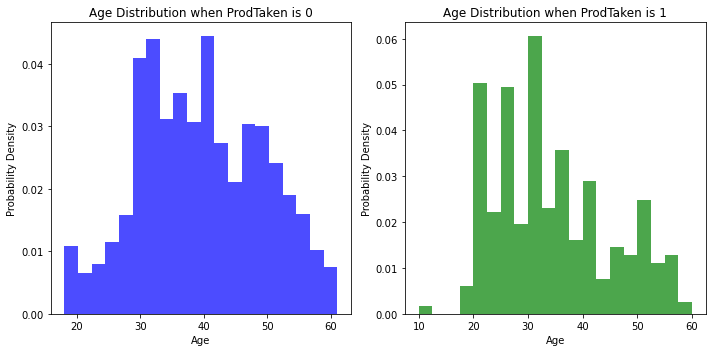

In [10]:
# プロットの設定
plt.figure(figsize=(10, 5))

# 'ProdTaken'が0の場合の'Age'のヒストグラム（確率密度で表示）
plt.subplot(1, 2, 1)
plt.hist(train1[train1['ProdTaken'] == 0]['Age'], bins=20, alpha=0.7, color='blue', density=True)
plt.title('Age Distribution when ProdTaken is 0')
plt.xlabel('Age')
plt.ylabel('Probability Density')

# 'ProdTaken'が1の場合の'Age'のヒストグラム（確率密度で表示）
plt.subplot(1, 2, 2)
plt.hist(train1[train1['ProdTaken'] == 1]['Age'], bins=20, alpha=0.7, color='green', density=True)
plt.title('Age Distribution when ProdTaken is 1')
plt.xlabel('Age')
plt.ylabel('Probability Density')

plt.tight_layout()
plt.show()

In [18]:
def frequency_plot(feature):
    age_prod_taken_rate = train1.groupby(feature)['ProdTaken'].mean()

    age_counts = train1[feature].value_counts().sort_index()

    plt.figure(figsize=(14, 12))

    plt.subplot(2, 1, 1)
    age_prod_taken_rate.plot(kind='bar', color='skyblue', alpha=0.7)
    plt.title(f'Percentage of ProdTaken = 1 by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Percentage')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    age_counts.plot(kind='bar', color='lightgreen', alpha=0.7)
    plt.title(f'Number of People by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

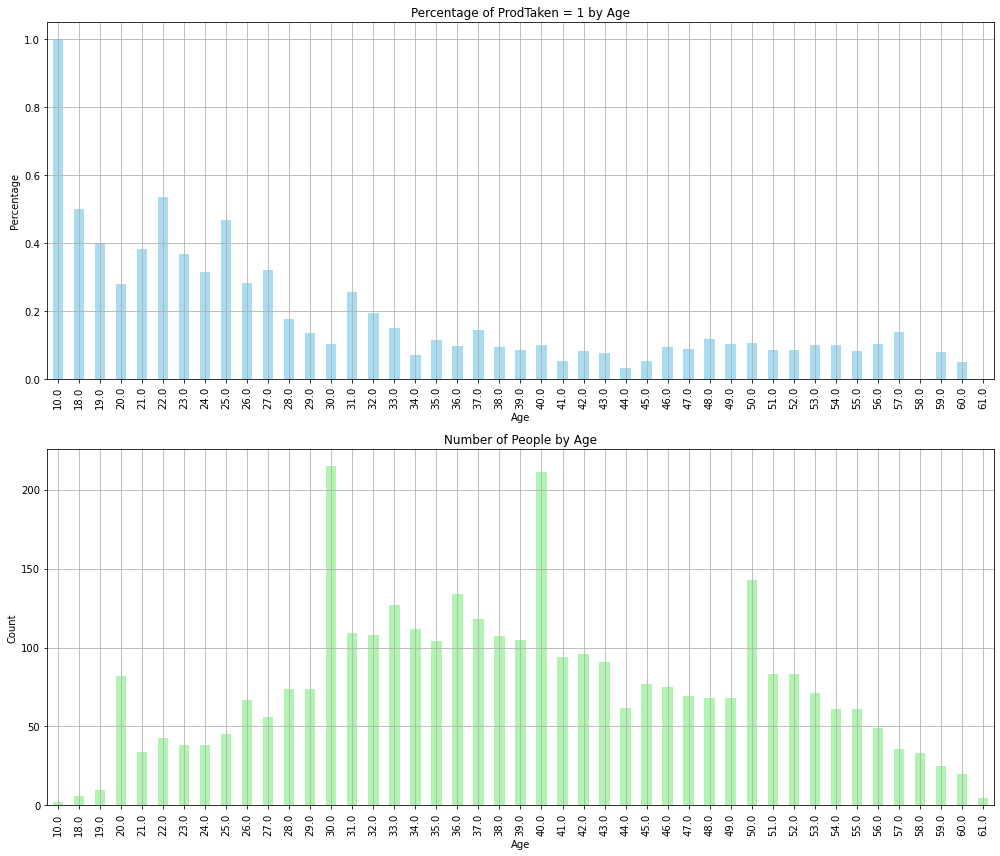

In [22]:
# Age
frequency_plot('Age')

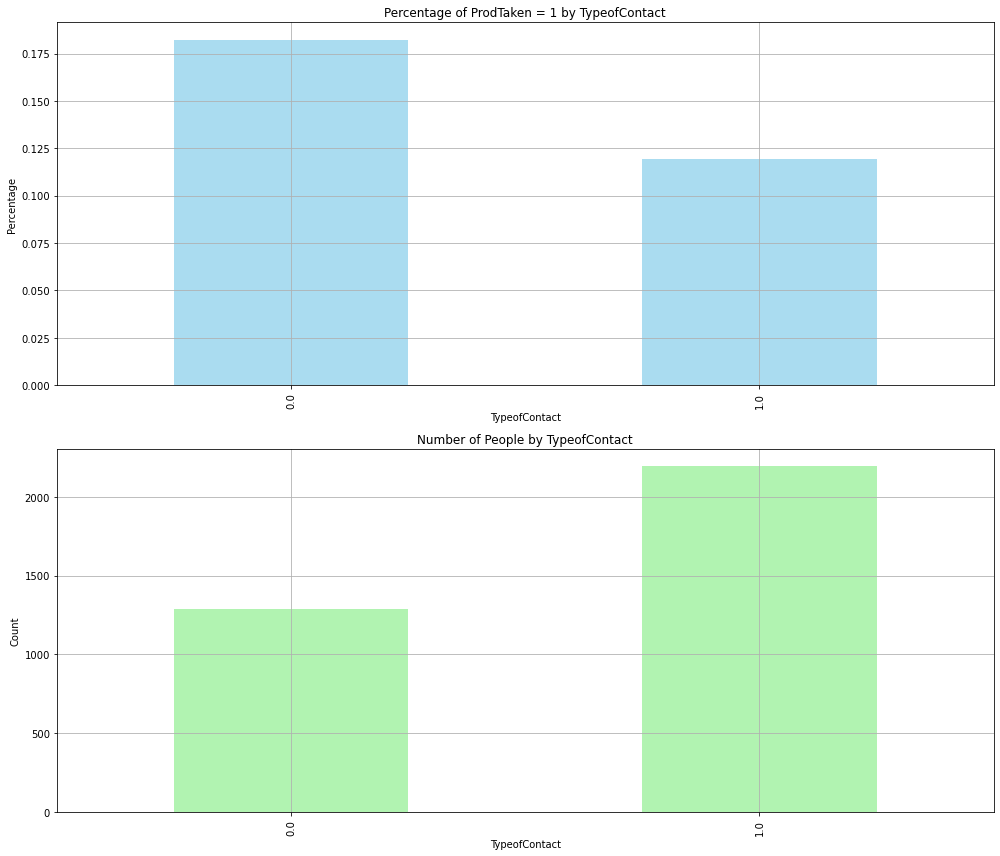

In [21]:
# TypeofContact
frequency_plot('TypeofContact')

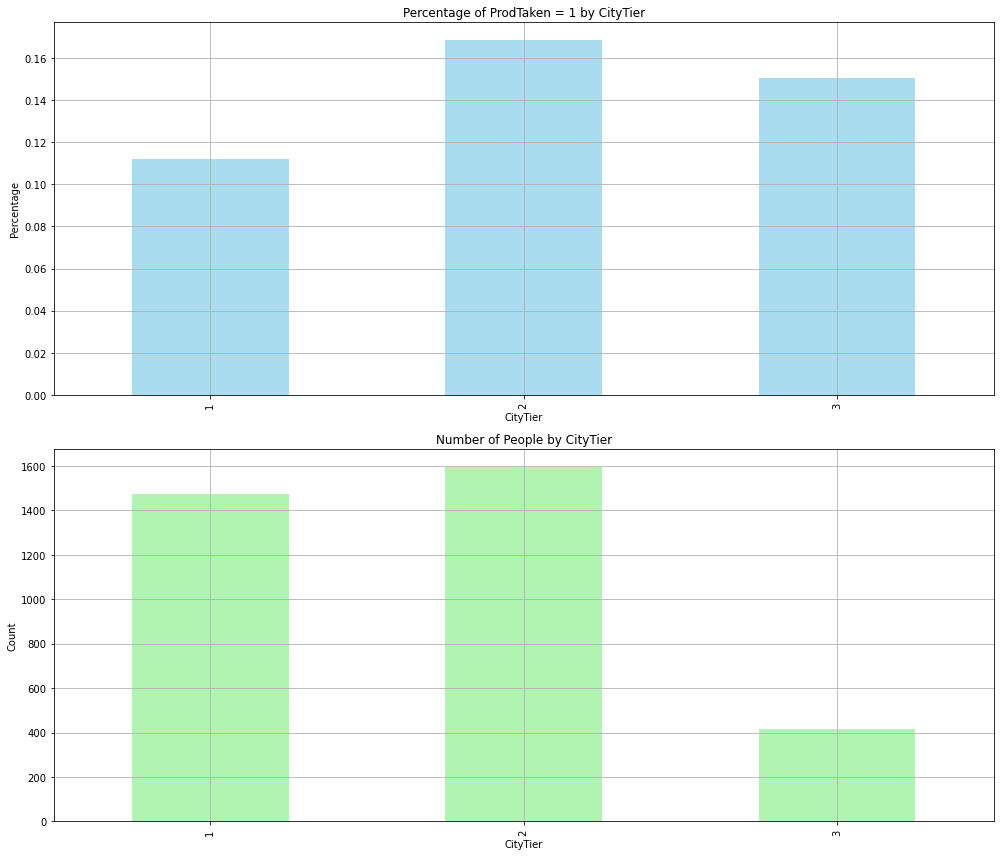

In [23]:
# 'CityTier'
frequency_plot('CityTier')

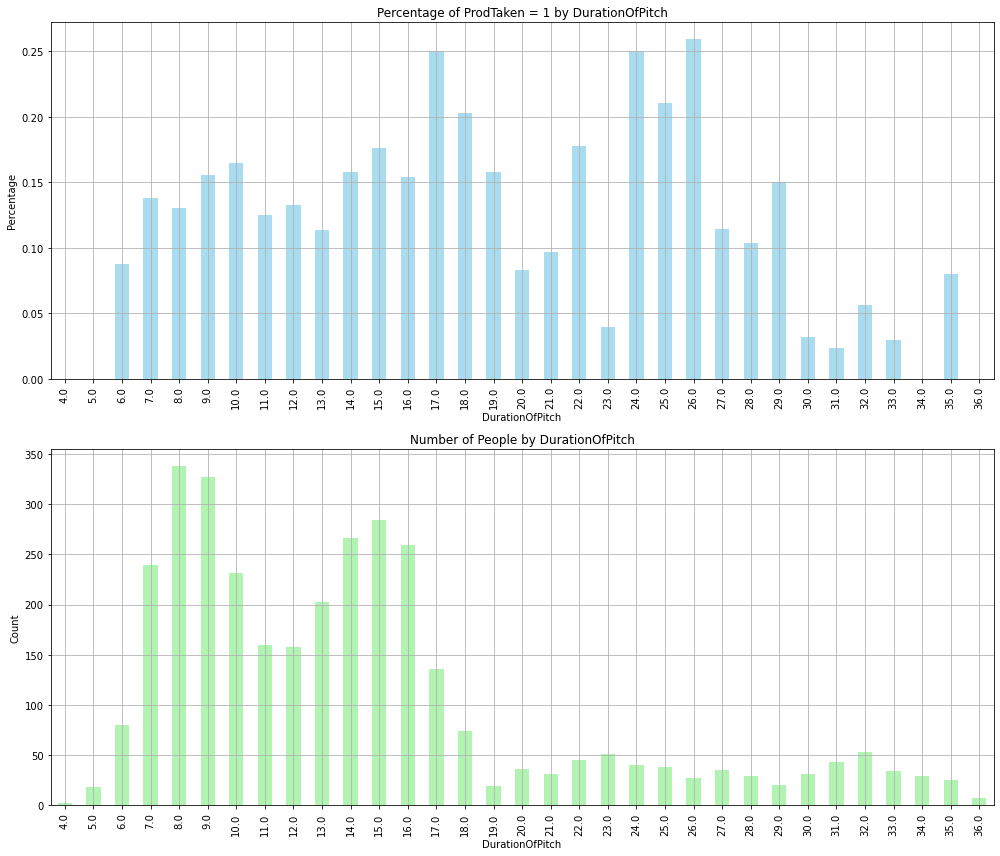

In [24]:
# DurationOfPitch
frequency_plot('DurationOfPitch')

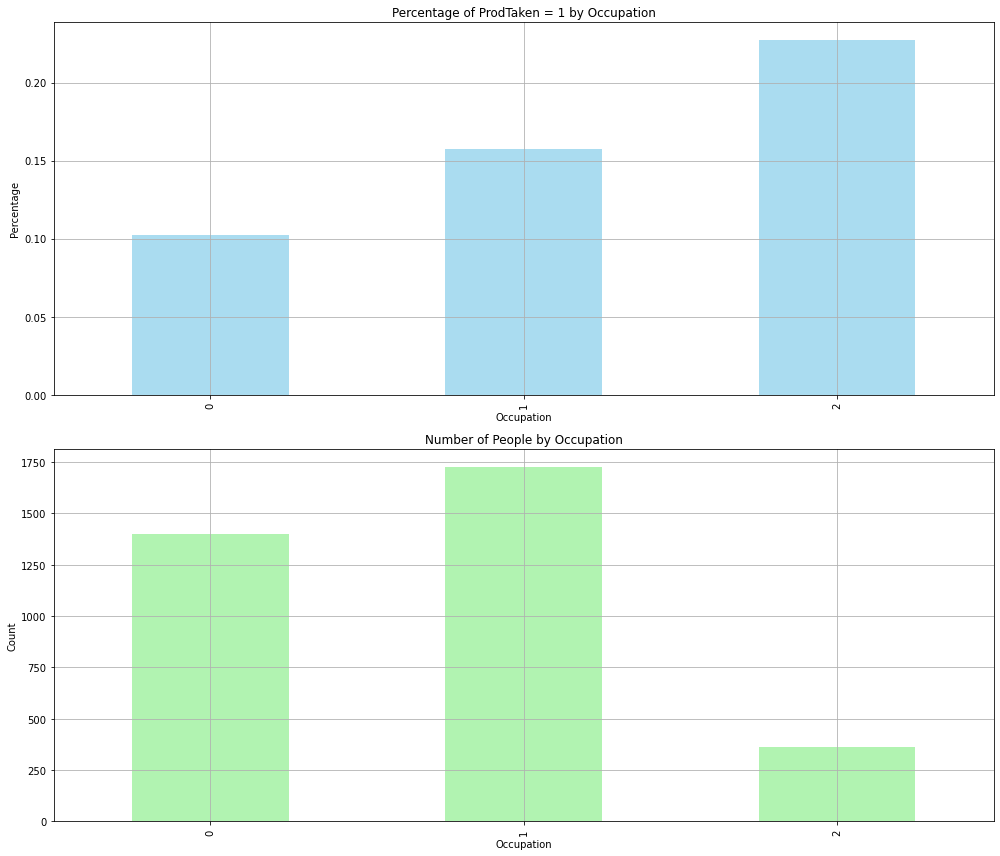

In [26]:
# Occupation
frequency_plot('Occupation')

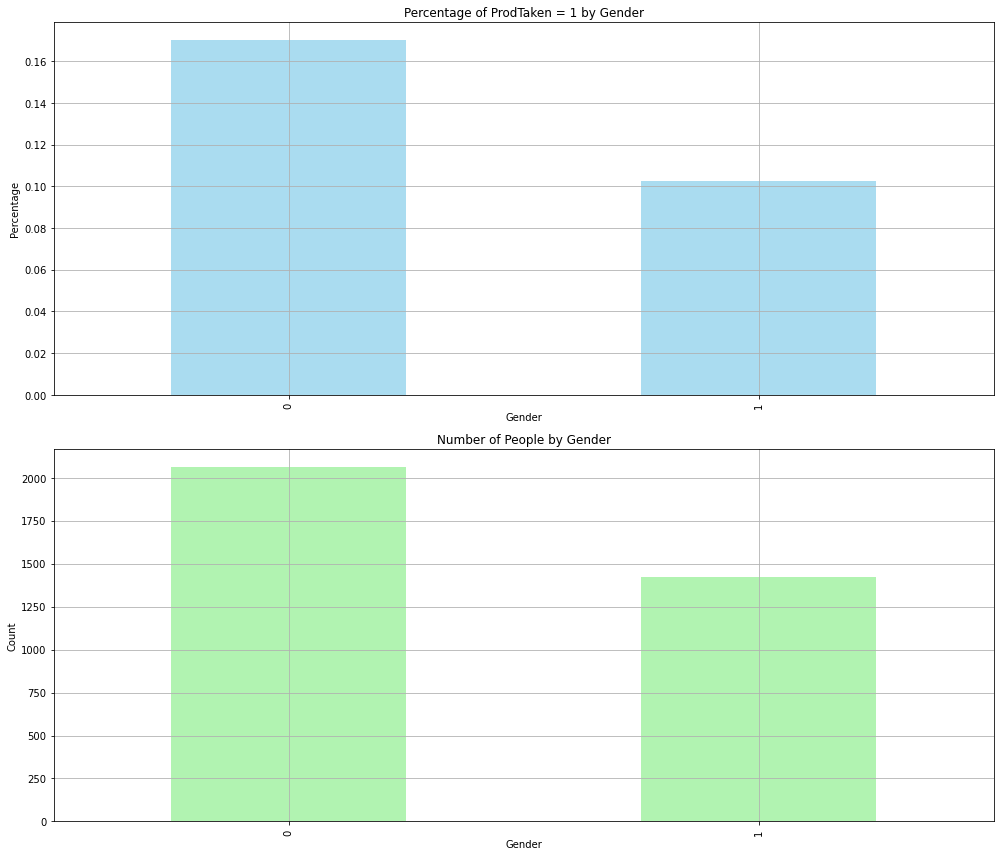

In [27]:
# Gender
frequency_plot('Gender')

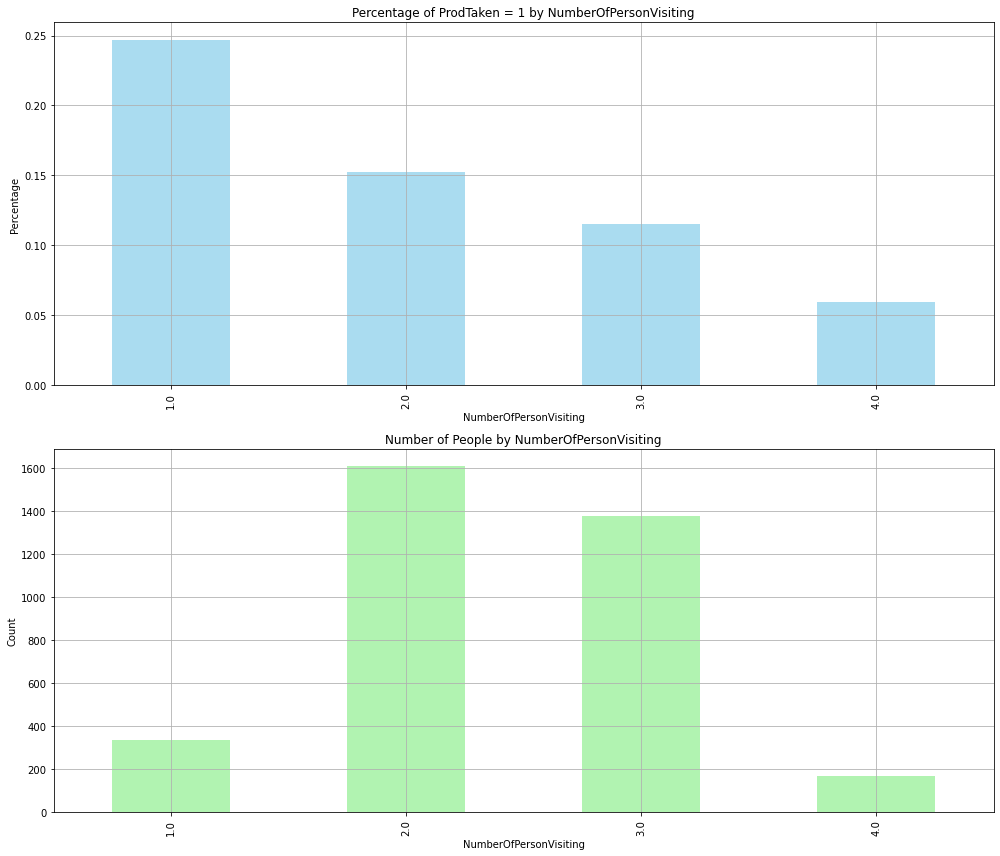

In [29]:
# NumberOfPersonVisiting
frequency_plot('NumberOfPersonVisiting')

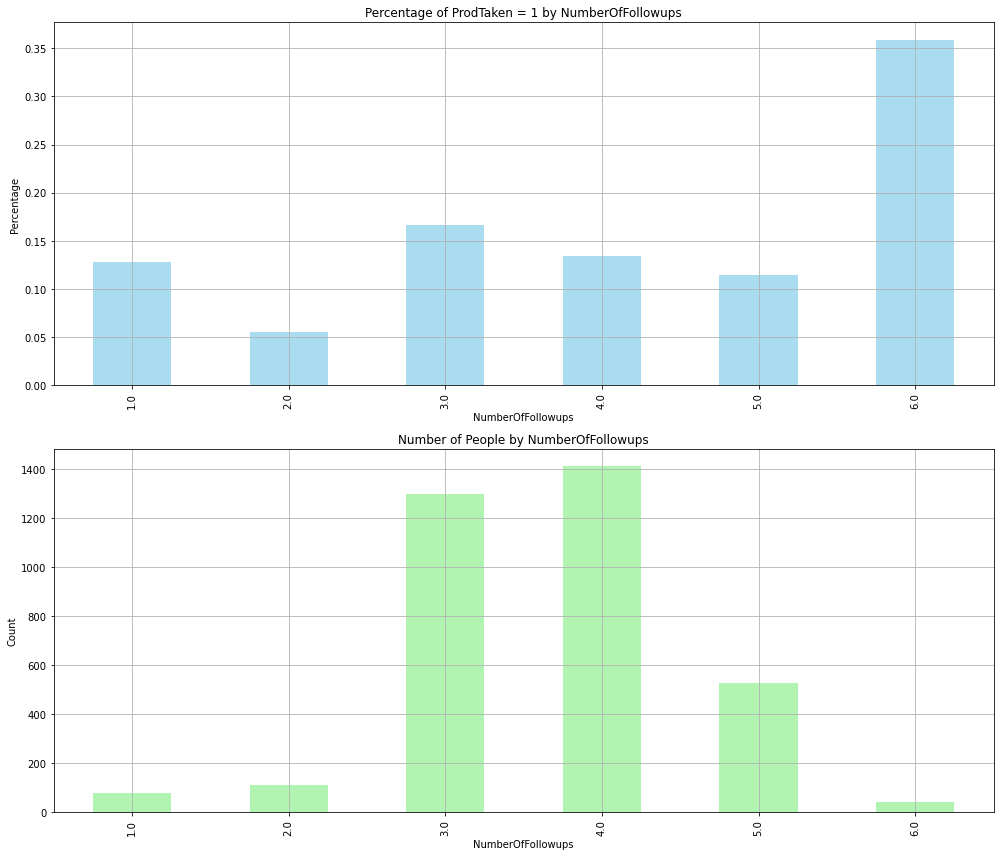

In [30]:
# NumberOfFollowups
frequency_plot('NumberOfFollowups')

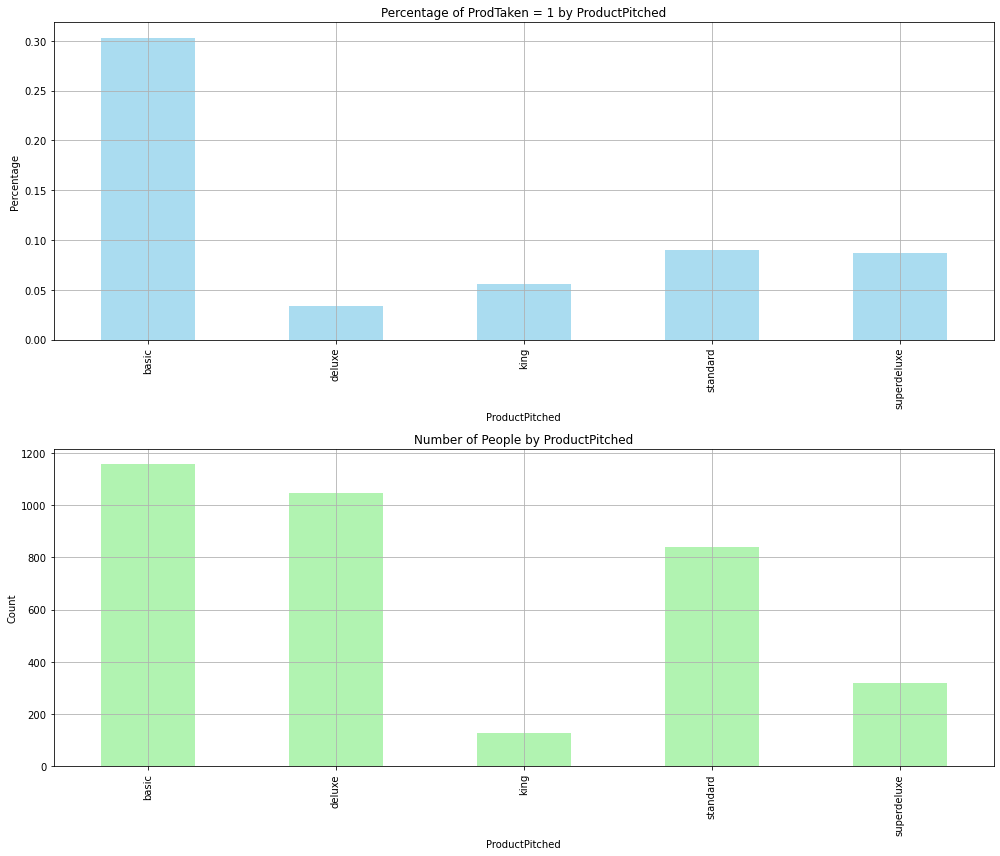

In [31]:
# ProductPitched
frequency_plot('ProductPitched')

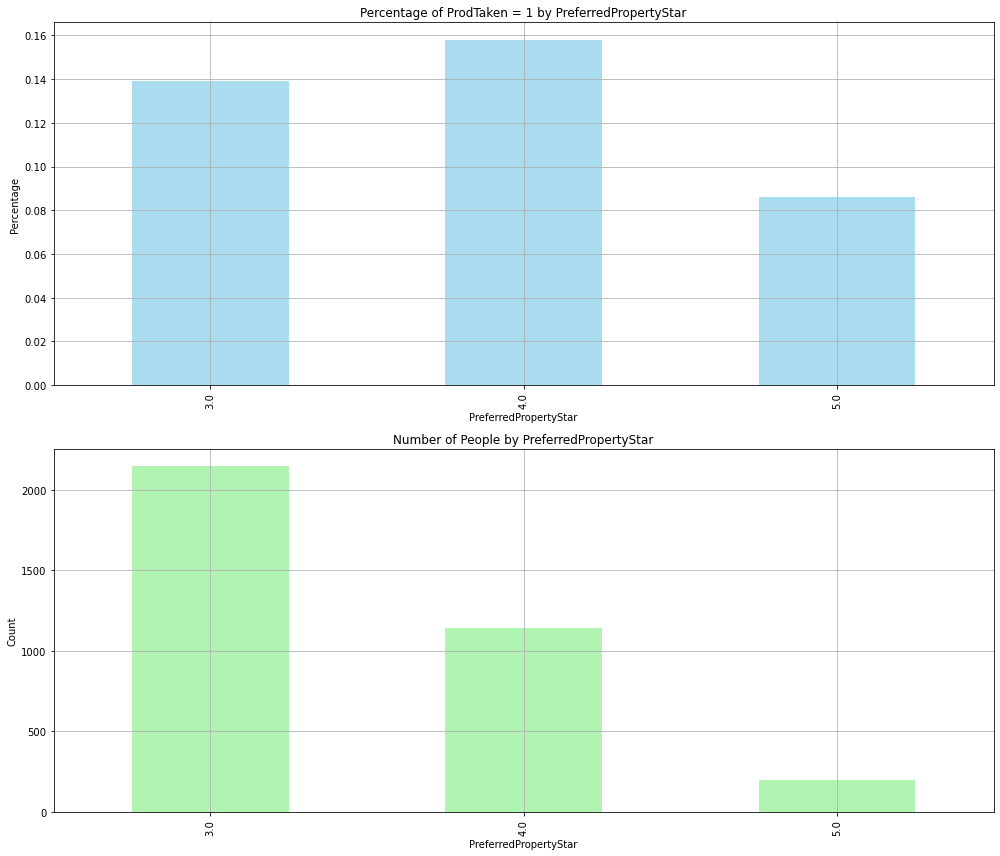

In [32]:
# PreferredPropertyStar
frequency_plot('PreferredPropertyStar')

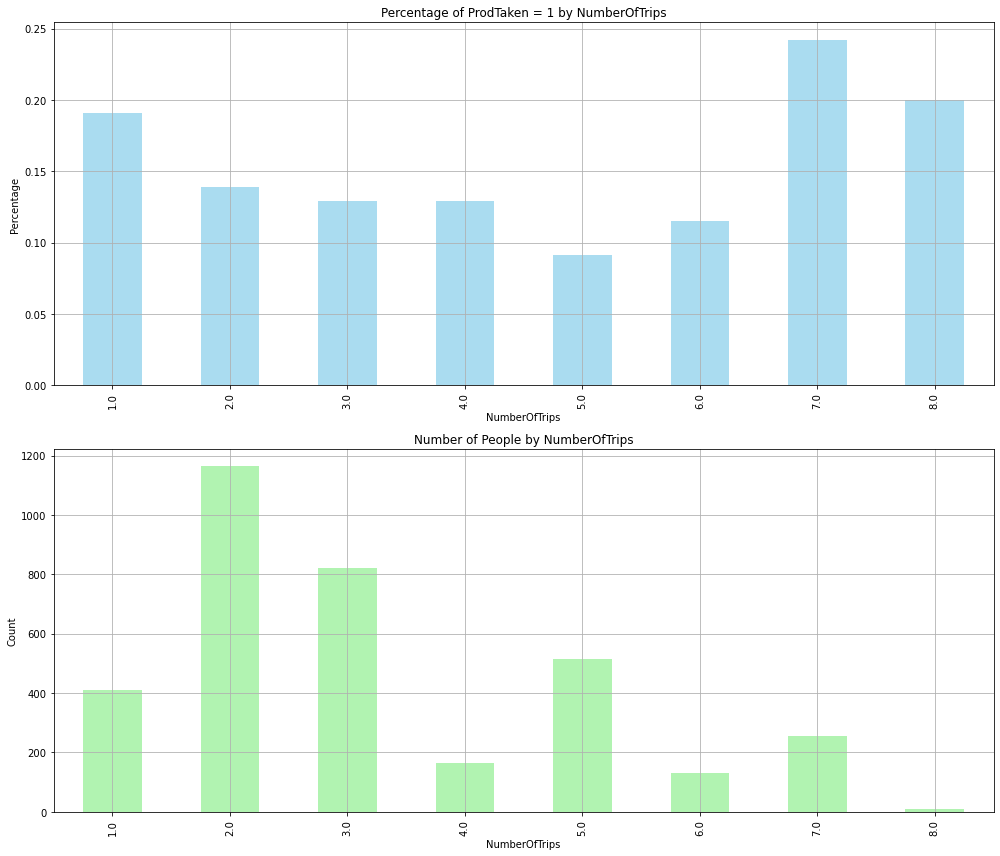

In [33]:
# NumberOfTrips
frequency_plot('NumberOfTrips')

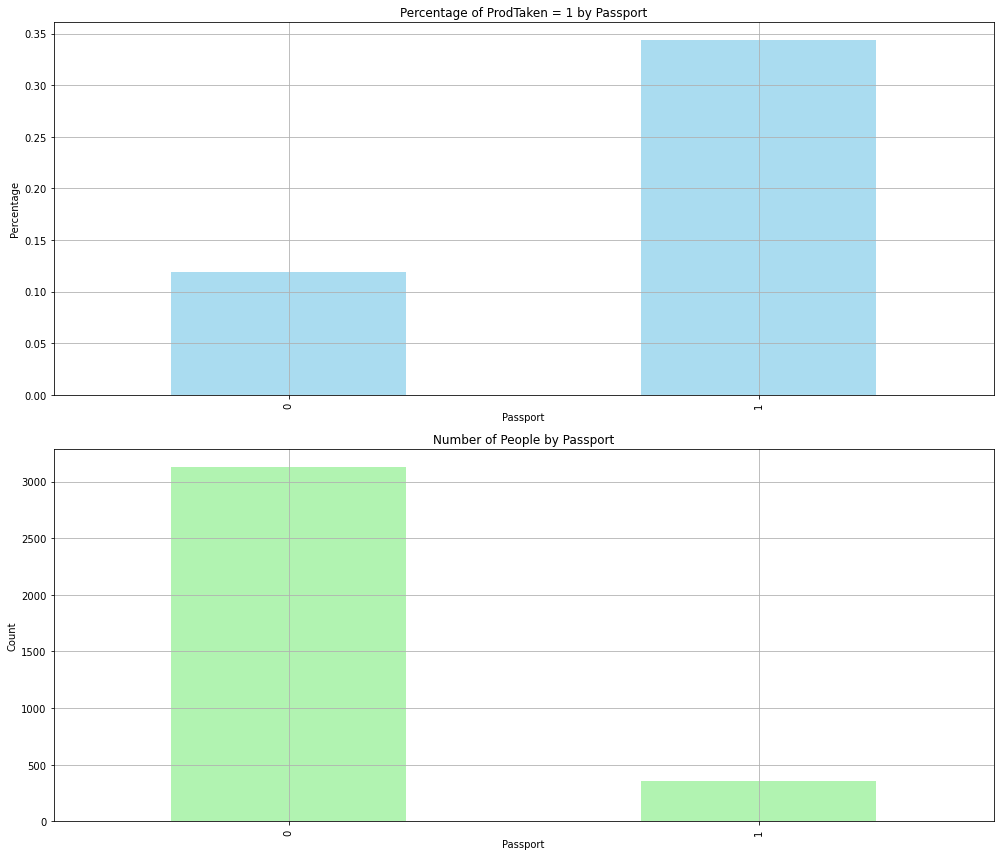

In [34]:
# Passport
frequency_plot('Passport')

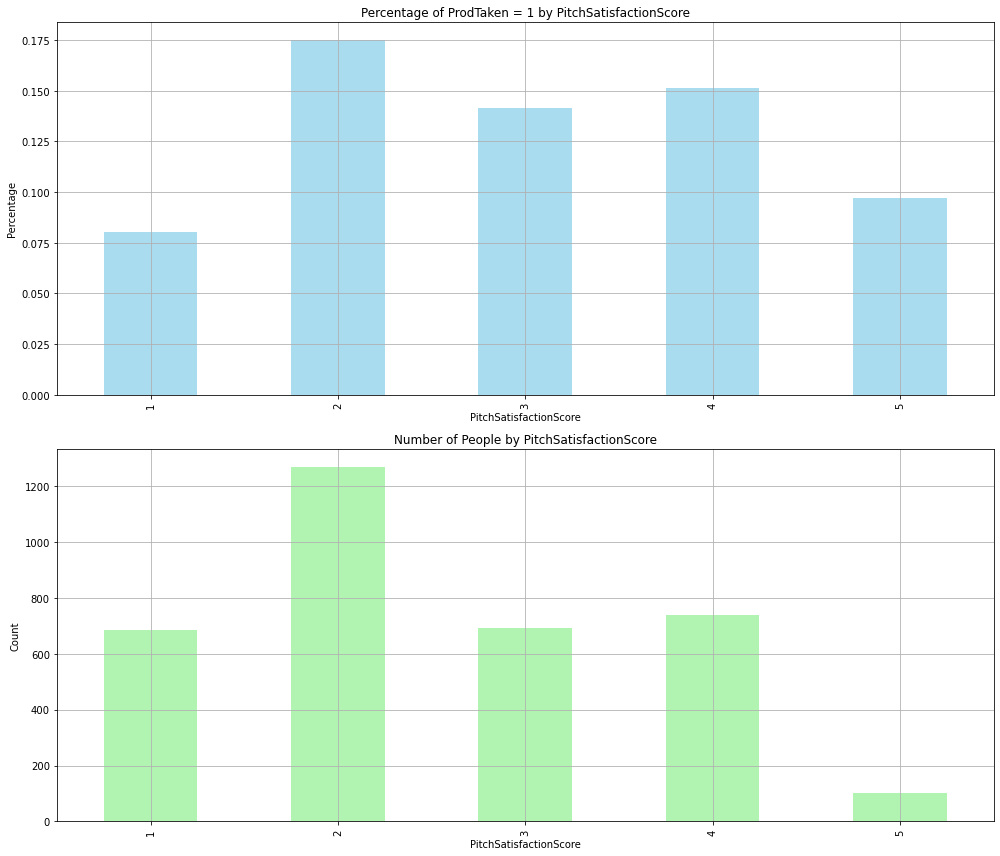

In [35]:
# PitchSatisfactionScore
frequency_plot('PitchSatisfactionScore')

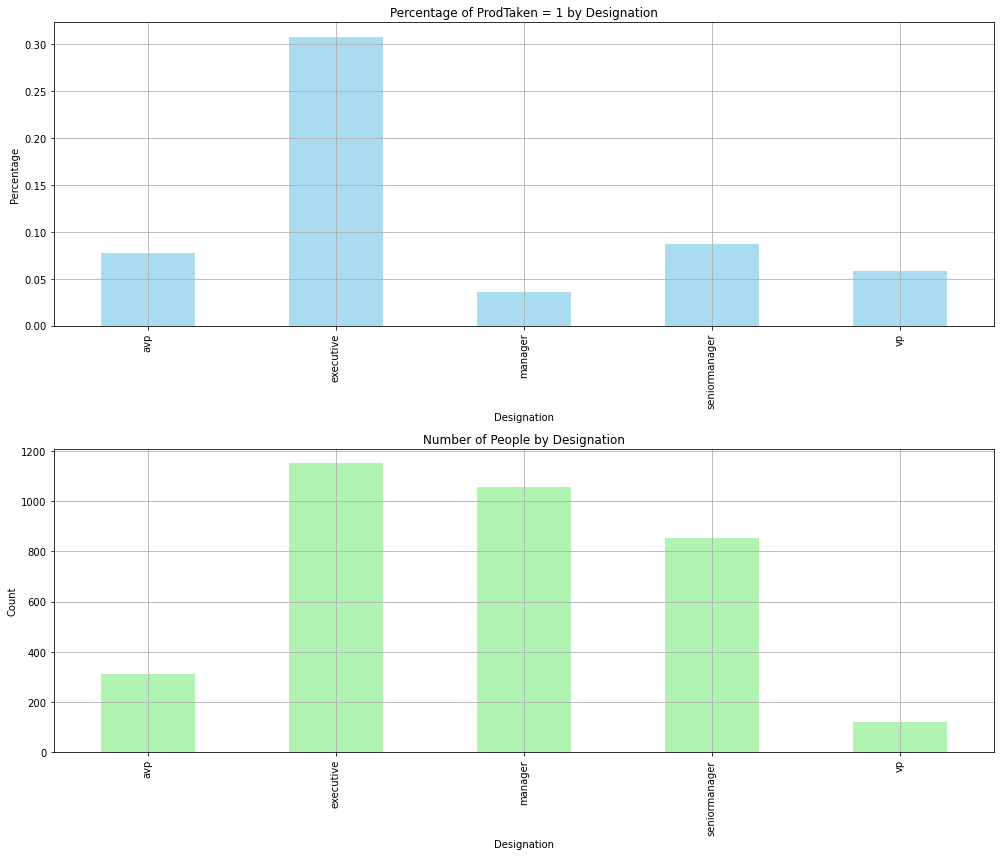

In [38]:
# Designation
frequency_plot('Designation')

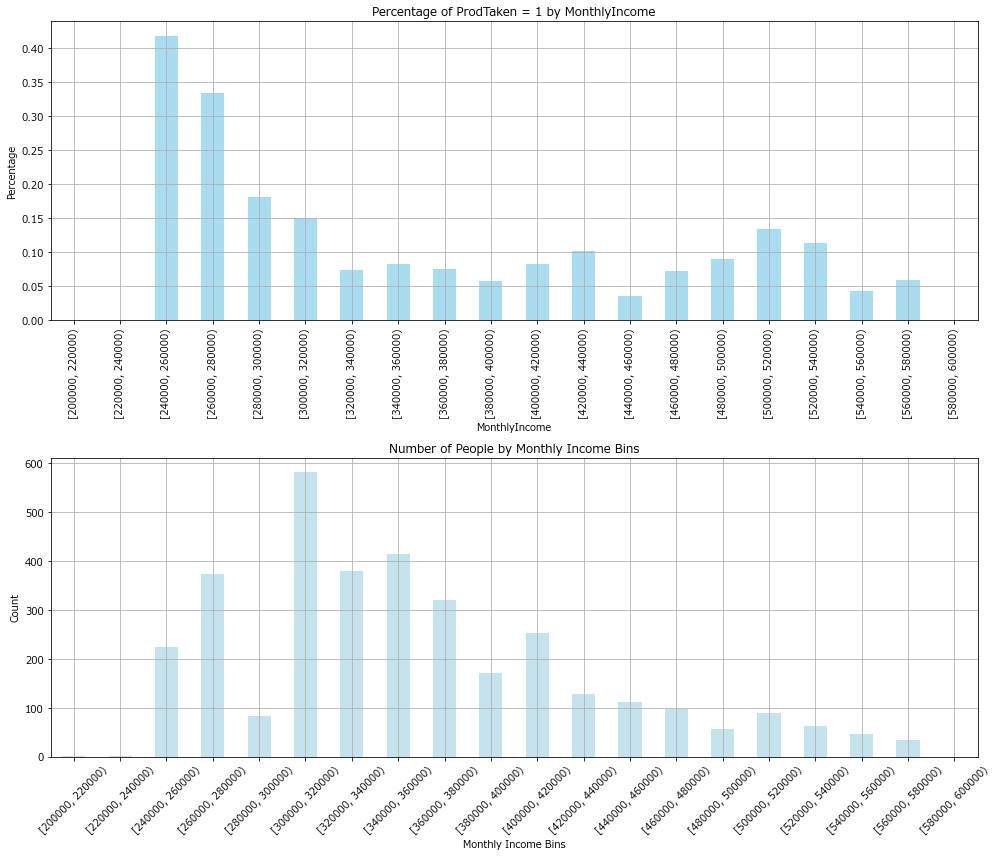

In [53]:
# MonthlyIncome
# 'MonthlyIncome' の値を階級に分ける
# ここでは例として100000円ごとの階級を作成
bins = range(int(train1['MonthlyIncome'].min()), int(train1['MonthlyIncome'].max()) + 20000, 20000)
train1['IncomeBin'] = pd.cut(train1['MonthlyIncome'], bins=bins, right=False)

# 階級ごとに 'ProdTaken' が 1 の割合を計算
income_prod_taken_rate = train1.groupby('IncomeBin')['ProdTaken'].mean()
# 階級ごとの人数をカウント
income_counts = train1['IncomeBin'].value_counts().sort_index()

# プロットの設定
plt.figure(figsize=(14, 12))

# 上のサブプロット：ProdTaken = 1 の割合
plt.subplot(2, 1, 1)  # 2行1列のグリッドの最初の位置
income_prod_taken_rate.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Percentage of ProdTaken = 1 by MonthlyIncome')
plt.xlabel('MonthlyIncome')
plt.ylabel('Percentage')
plt.grid(True)

# 下のサブプロット：階級ごとの収入の人数
plt.subplot(2, 1, 2)  # 2行1列のグリッドの2番目の位置
income_counts.plot(kind='bar', color='lightblue', alpha=0.7)
plt.title('Number of People by Monthly Income Bins')
plt.xlabel('Monthly Income Bins')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

train1 = train1.drop(['IncomeBin'],axis=1)

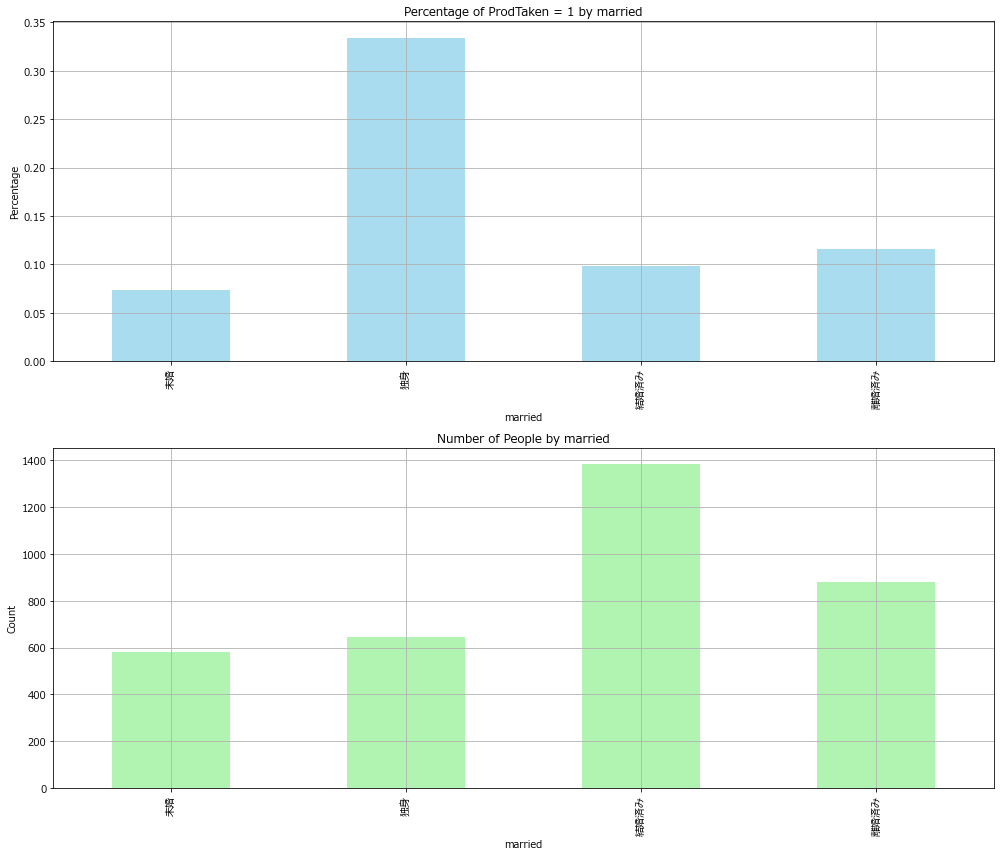

In [50]:
# married
frequency_plot('married')

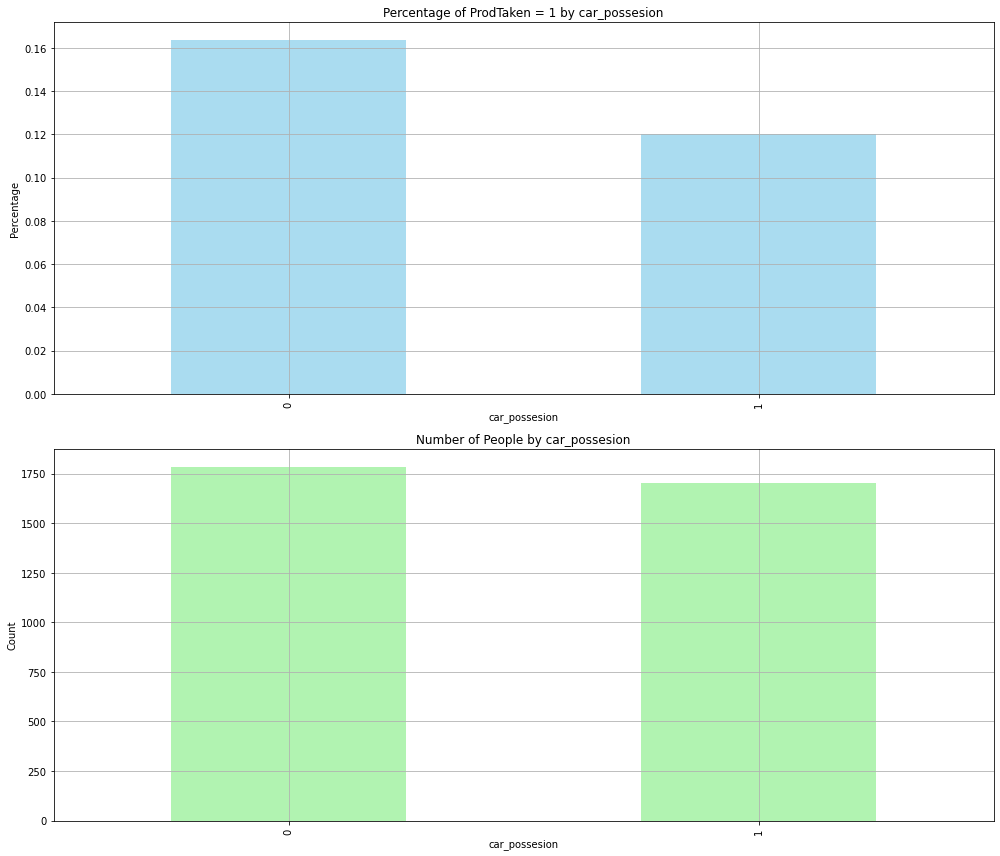

In [46]:
# car_possesion
frequency_plot('car_possesion')

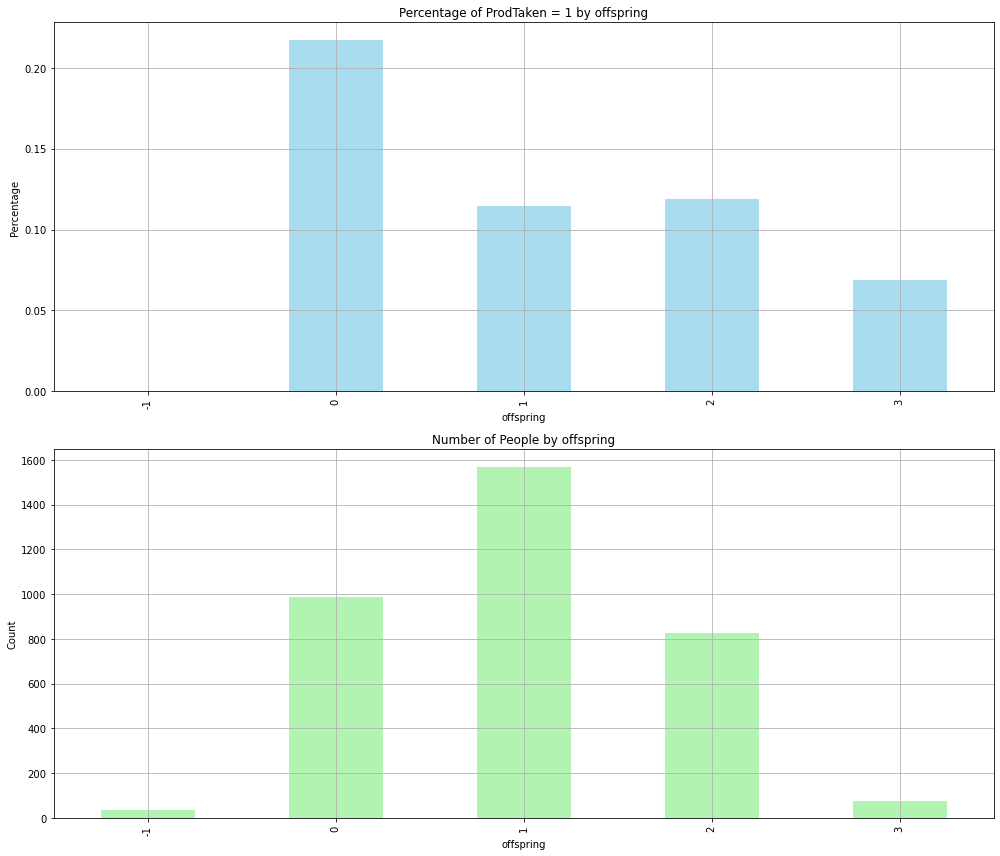

In [47]:
# offspring
frequency_plot('offspring')

In [43]:
# 変数名と列番号の対応を表示
col = pd.DataFrame(train1.columns.values).T
col

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,ProdTaken,married,car_possesion,offspring,IncomeBin


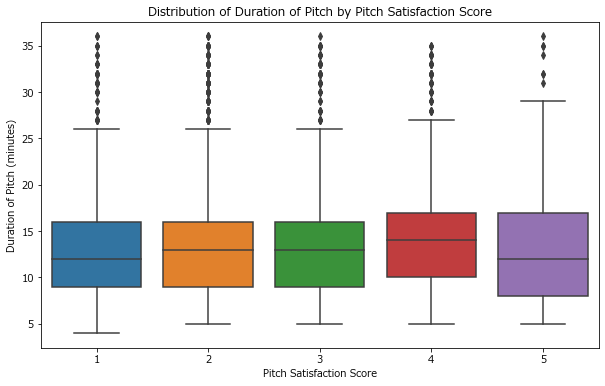

In [63]:
# 箱ひげ図で表示
plt.figure(figsize=(10, 6))
sns.boxplot(x='PitchSatisfactionScore', y='DurationOfPitch', data=train1)
plt.title('Distribution of Duration of Pitch by Pitch Satisfaction Score')
plt.xlabel('Pitch Satisfaction Score')
plt.ylabel('Duration of Pitch (minutes)')
plt.show()

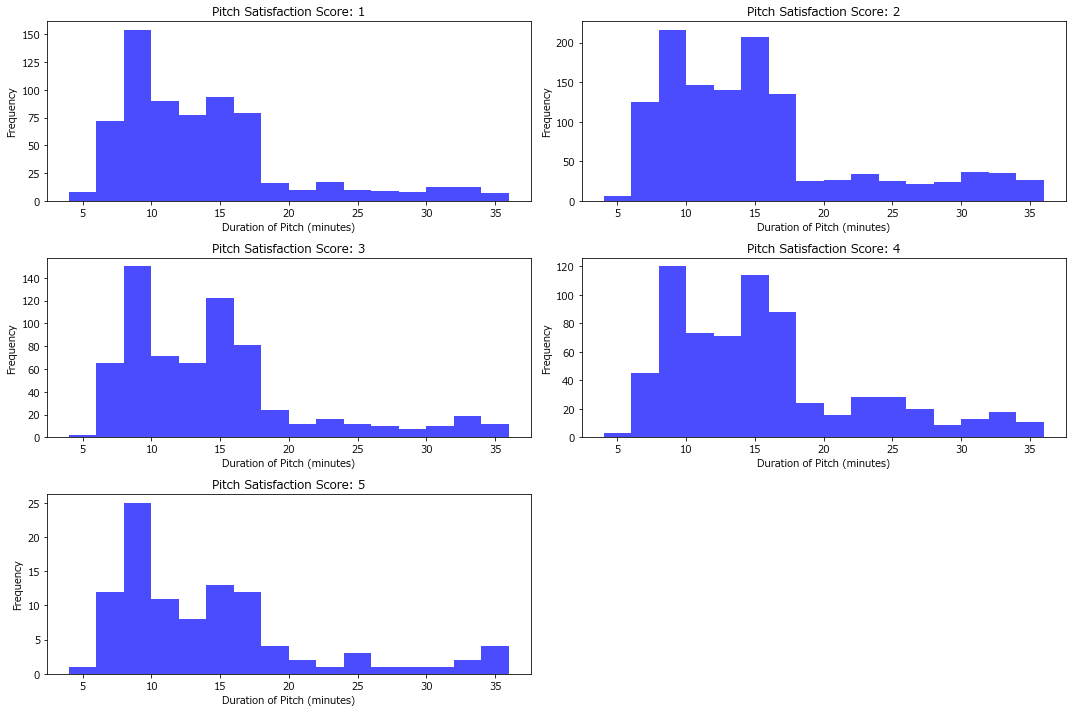

In [79]:
# 階級幅を2分間隔で設定
min_duration = train1['DurationOfPitch'].min()
max_duration = train1['DurationOfPitch'].max()
bins = list(range(int(min_duration), int(max_duration) + 2, 2))  # max + 2 で最後の階級を含める

# PitchSatisfactionScore の各値（1から5）ごとに別々のグラフを描く
scores = sorted(train1['PitchSatisfactionScore'].unique())  # Unique scores

plt.figure(figsize=(15, 10))  # 全体の図のサイズを設定

for i, score in enumerate(scores, 1):
    plt.subplot(3, 2, i)  # 3行2列のサブプロット
    subset = train1[train1['PitchSatisfactionScore'] == score]
    plt.hist(subset['DurationOfPitch'], bins=bins, alpha=0.7, color='blue')
    plt.title(f'Pitch Satisfaction Score: {score}')
    plt.xlabel('Duration of Pitch (minutes)')
    plt.ylabel('Frequency')
    plt.tight_layout()  # グラフ同士が重ならないようにレイアウトを調整

plt.show()